In [1]:
import numpy as np
import pandas as pd
import re
import string
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/wzl20/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def data_cleaning(raw_data): 
    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits)) 
    words = raw_data.lower().split() 
    # stops = set(stopwords.words( "english")) 
    stops = set(stopwords)
    # stops = stopwords.words('english')
    useful_words = [w for w in words if not w in stops] 
    return( " ".join(useful_words))

In [3]:
df = pd.read_csv("../B_Data_Cleaning/synthetic_reviews_all_trial_1.csv")
df["Review"] = df["Review"].astype("str")
df['Review']=df['Review'].apply(data_cleaning) 
df

,Review,Recommended or Not Recommended
0,idols hex scifistoryelements airborne underwor...,True
1,ablazing ｉｔｓ alanah дрянь ammunition unbreakab...,True
2,doubletapping overcrowded critiquer minesweepe...,True
3,puffing mild miniboss vybouchnou selected bonl...,True
4,rapid bpoliceb seeen contagion whazoo,True
...,...,...
16570,gathering acording damagedealing hquests guide...,False
16571,ghameplay houdini viks chews planed ao corpotr...,False
16572,oldgen excelentes httpswwwyoutubecomwatchvzfrc...,False
16573,preferência fixespolish compli platoon caminan...,False


In [4]:
df['Recommend'] = df['Recommended or Not Recommended'].apply(lambda x: 'Recommended' if x == True else 'Not Recommended')
df.drop(['Recommended or Not Recommended'], axis=1, inplace=True)
df

,Review,Recommend
0,idols hex scifistoryelements airborne underwor...,Recommended
1,ablazing ｉｔｓ alanah дрянь ammunition unbreakab...,Recommended
2,doubletapping overcrowded critiquer minesweepe...,Recommended
3,puffing mild miniboss vybouchnou selected bonl...,Recommended
4,rapid bpoliceb seeen contagion whazoo,Recommended
...,...,...
16570,gathering acording damagedealing hquests guide...,Not Recommended
16571,ghameplay houdini viks chews planed ao corpotr...,Not Recommended
16572,oldgen excelentes httpswwwyoutubecomwatchvzfrc...,Not Recommended
16573,preferência fixespolish compli platoon caminan...,Not Recommended


Recommended        11050
Not Recommended     5525
Name: Recommend, dtype: int64


<AxesSubplot:>

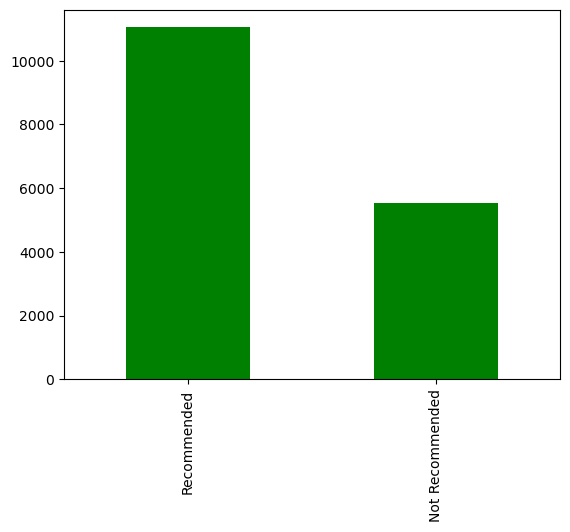

In [5]:
print(df['Recommend'].value_counts())
df['Recommend'].value_counts().plot.bar(color='green')

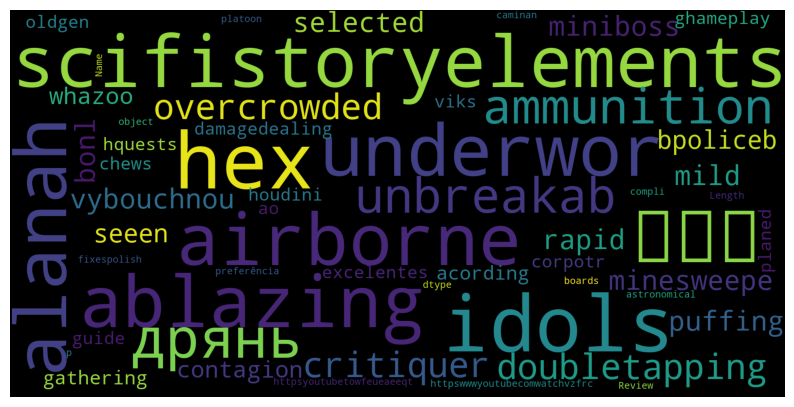

In [6]:
def generate_wordcloud(data, title=None):
    wordcloud = WordCloud(
        stopwords=stopwords, max_words=100, max_font_size=40, scale=4
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(df["Review"])


In [7]:
# 5. Import API’s from Tensorflow required to build the LSTM Model
import tensorflow as tf

# from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [8]:
# 6. Tokenize words

y = df["Recommend"].values
reviews = df["Review"]
# test_reviews = df_test["review"]
max_features = 16000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(reviews))
list_tokenized = tokenizer.texts_to_sequences(reviews)
df["Review"] = list_tokenized
list_tokenized = pad_sequences(list_tokenized, maxlen=929)
df["Review"] = list(list_tokenized)
# df["Review"] = list_tokenized
df


,Review,Recommend
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Recommended
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Recommended
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Recommended
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Recommended
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Recommended
...,...,...
16570,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Not Recommended
16571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Not Recommended
16572,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Not Recommended
16573,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Not Recommended


In [9]:
# 7. Now lets define the callbacks that is necessary to perform early stopping and saving model checkpoints.

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True
def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):    
    checkpoint_path = model_name+"_cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  save_weights_only=True, verbose=1)
    callbacks = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback]
    )
    return history

In [10]:
# define graph function
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [11]:
df.head()
df["Recommend"] = df["Recommend"].map(lambda x: int(1) if x=="Recommended" else int(0))
df.head()
# df["Review"] = np.array(df["Review"])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(df["Review"], df["Recommend"], test_size=0.33, random_state=42)
X_train

6108     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9902     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
11902    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
12370    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
13147    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
11284    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
11964    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5390     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
860      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15795    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: Review, Length: 11105, dtype: object

In [12]:
X_train = X_train.values.tolist()
y_train = y_train.values.tolist()

# X_train = np.array(X_train, dtype=object)
# y_train = np.array(y_train, dtype=object)

# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_train
y_tensor = tf.convert_to_tensor(y_train, dtype=tf.int64) 
X_tensor = tf.convert_to_tensor(X_train, dtype=tf.int64) 
# X_tensor = tf.convert_to_tensor(X_train, dtype=tf.object) 


In [13]:
X_test = X_test.values.tolist()
y_test = y_test.values.tolist()

y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int64) 
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.int64) 

In [14]:
# define predict function
def predict_func(model):
  prediction = model.predict(X_test_tensor)
  y_pred = (prediction > 0.5)
  # df_test["Recommend"] = df_test.index.map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
  # y_test = df_test["Recommend"]
  cf_matrix = confusion_matrix(y_pred, y_test_tensor)
  f1_score_calc = cf_matrix[0][0] / (cf_matrix[0][0] + 0.5 * (cf_matrix[0][1] + cf_matrix[1][0]))
  print('F1-score: %.3f' % f1_score_calc)
  print("Confusion Matrix : ", cf_matrix)
  return f1_score_calc

In [15]:
class Model_C():
  def __new__(self):
    embed_size = 64
    model = Sequential()
    model.add(Embedding(max_features, embed_size, mask_zero=False))
    model.add(Bidirectional(LSTM(75, return_sequences = True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.03))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    # opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    # opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model
    
model_c = Model_C()
history_c = train_model(model_c, "model_c", 5, 64, X_tensor, y_tensor,0.2)
model_c_score = predict_func(model_c)

Epoch 1/5


2022-12-18 20:11:56.951758: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


64/64 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6432
Epoch 1: saving model to model_c_cp-0001.ckpt
64/64 [==============================] - 114s 2s/step - loss: 0.6594 - accuracy: 0.6432 - val_loss: 0.6325 - val_accuracy: 0.6740
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.6601
Epoch 2: saving model to model_c_cp-0002.ckpt
64/64 [==============================] - 112s 2s/step - loss: 0.6396 - accuracy: 0.6601 - val_loss: 0.6241 - val_accuracy: 0.6740
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.5716 - accuracy: 0.7148
Epoch 3: saving model to model_c_cp-0003.ckpt
64/64 [==============================] - 110s 2s/step - loss: 0.5716 - accuracy: 0.7148 - val_loss: 0.5936 - val_accuracy: 0.6929
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8533
Epoch 4: saving model to model_c_cp-0004.ckpt
64/64 [==============================] - 116s 2s/step - loss: 0.

In [16]:
model_c_score = predict_func(model_c)

171/171 [==============================] - 27s 160ms/step
F1-score: 0.564
Confusion Matrix :  [[ 982  698]
 [ 823 2967]]


In [17]:
print(model_c.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1024000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 150)        84000     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 150)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                2416      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1

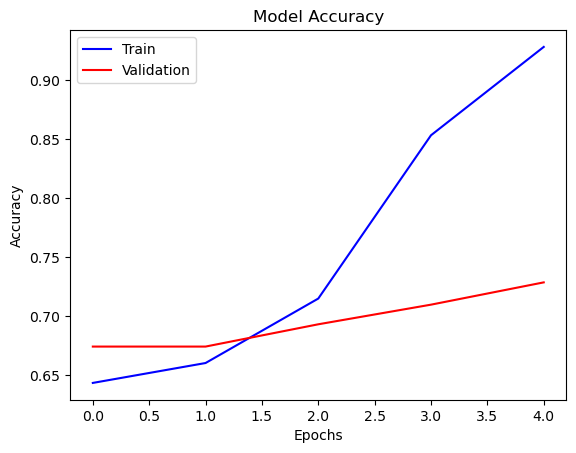

In [18]:
generate_graph(history_c)